In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import gzip
import os
%matplotlib inline

In [2]:
mnist_data_folder = '../data/MNIST_data/'

In [3]:
filename = [
["training_images",os.path.join(mnist_data_folder, "train-images-idx3-ubyte.gz")],
["test_images", os.path.join(mnist_data_folder, "t10k-images-idx3-ubyte.gz")],
["training_labels", os.path.join(mnist_data_folder, "train-labels-idx1-ubyte.gz")],
["test_labels", os.path.join(mnist_data_folder, "t10k-labels-idx1-ubyte.gz")]
]

#### We use an offset of 16 bytes while reading the images because the first byte of first image starts from the 16<sup>th</sup> byte.    
* Byte 0 to 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Header
* Byte 4 to 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Number of images in file
* Byte 8 to 11: &nbsp;&nbsp;&nbsp; Number of rows in each image
* Byte 12 to 15: &nbsp;&nbsp; Number of columns in each image

#### Similarly we use an offset of 8 bytes while reading labels because the first byte of first label starts from 8<sup>th</sup> byte.

In [4]:
mnist = {}
for name in filename[:2]:
    with gzip.open(name[1], 'rb') as f:
        mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28, 1)
        
for name in filename[-2:]:
    with gzip.open(name[1], 'rb') as f:
        #mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8).reshape(-1, 1)
        mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
        

In [5]:
print(mnist.keys())
print(mnist['training_images'].shape)
print(mnist['training_labels'].shape)
print(mnist['test_images'].shape)
print(mnist['test_labels'].shape)

dict_keys(['test_labels', 'training_images', 'test_images', 'training_labels'])
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [12]:
def display_image_grid(shape, images):
    rows = shape[0]
    cols = shape[1]
    f, ax = plt.subplots(rows, cols, figsize=(16, 11))
    f.tight_layout()
    i = 0
    for row in range(rows):
        for col in range(cols):
            image = images[i].squeeze()
            ax[row,col].imshow(image, cmap='gray')
            cv2.imwrite("test" + str(i) + ".png", image)
            i += 1
        row += 1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

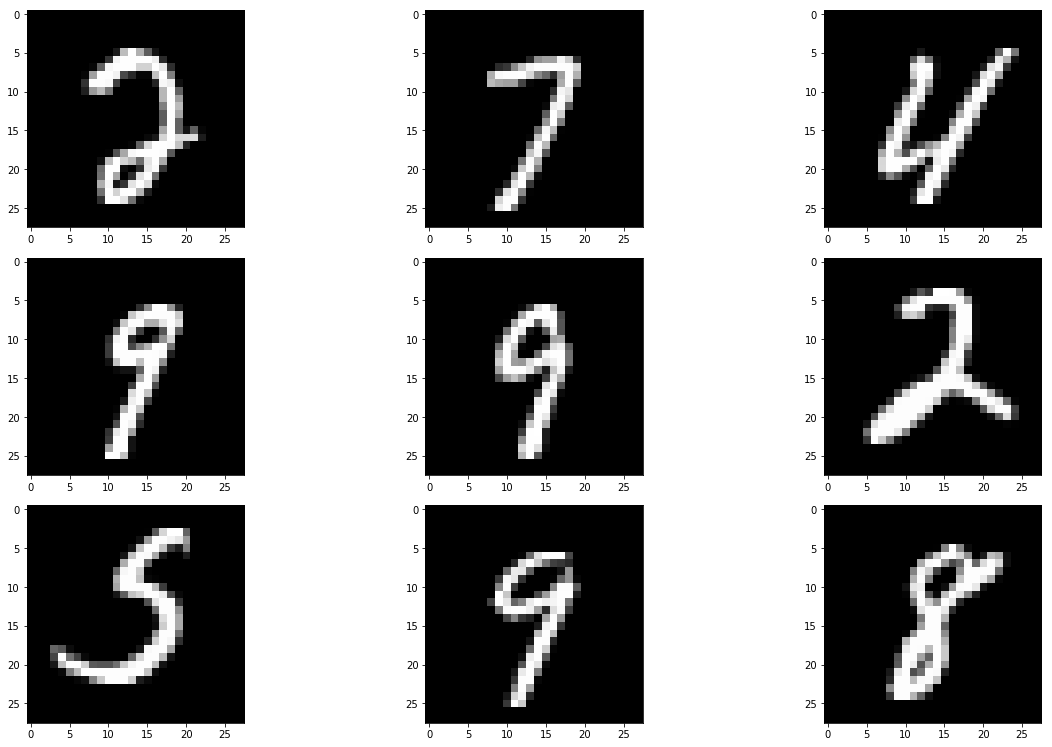

In [14]:
import random
index = random.randint(0, len(mnist['test_images']))
imgs = [mnist['test_images'][idx] for idx in range(index, index+10)]
display_image_grid((3, 3), imgs)

8
(28, 28, 1)
(28, 28)


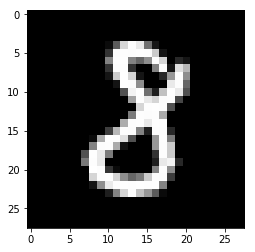

In [6]:
import random
index = random.randint(0, len(mnist['training_images']))
image = mnist['training_images'][index]
label = mnist['training_labels'][index]
print(label)
print(image.shape)
image = image.squeeze()
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(mnist['training_images'], mnist['training_labels'], test_size=0.20, random_state=42)
X_test = mnist['test_images']
y_test = mnist['test_labels']


In [16]:
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))
print()
print("Image Shape: {}".format(X_train.shape))
print("Label Shape: {}".format(y_train.shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (48000, 28, 28, 1)
Label Shape: (48000,)

Training Set:   48000 samples
Validation Set: 12000 samples
Test Set:       10000 samples


The LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

In [17]:
# Pad images with 0s
# np.pad(np_array, ((axis_0 first item, axis_0 second item),(top, bottom),(left, right),(axis_3 first item, axis_3 last item)))
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


In [18]:
import tensorflow as tf
print(tf.__version__)

C:\Users\Admin\Miniconda3\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1


In [19]:
def normalize_images(x):
    x = (x-128)/256.0
    return x

In [20]:
X_train = normalize_images(X_train)
X_validation = normalize_images(X_validation)
X_test = normalize_images(X_test)
print("Range of training data(min, max): [{},{}]".format(np.min(X_train), np.max(X_train)))
print("Range of validation data(min, max): [{},{}]".format(np.min(X_validation), np.max(X_validation)))
print("Range of test data(min, max): [{},{}]".format(np.min(X_test), np.max(X_test)))

Range of training data(min, max): [0.0,0.99609375]
Range of validation data(min, max): [0.0,0.99609375]
Range of test data(min, max): [0.0,0.99609375]


In [21]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    return logits

In [22]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

In [23]:
EPOCHS = 20
BATCH_SIZE = 128

In [24]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [25]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
from sklearn.utils import shuffle
training_acc = []
validation_acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            #print(sess.run(tf.shape(logits), feed_dict={x:batch_x}))
            #print("Shape of y")
            #print(sess.run(tf.shape(one_hot_y), feed_dict={y:batch_y}))
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        training_acc.append(training_accuracy)
        validation_acc.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, '../models/lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.779
Validation Accuracy = 0.777

EPOCH 2 ...
Training Accuracy = 0.842
Validation Accuracy = 0.839

EPOCH 3 ...
Training Accuracy = 0.876
Validation Accuracy = 0.873

EPOCH 4 ...
Training Accuracy = 0.885
Validation Accuracy = 0.884

EPOCH 5 ...
Training Accuracy = 0.901
Validation Accuracy = 0.898

EPOCH 6 ...
Training Accuracy = 0.904
Validation Accuracy = 0.900

EPOCH 7 ...
Training Accuracy = 0.915
Validation Accuracy = 0.912

EPOCH 8 ...
Training Accuracy = 0.923
Validation Accuracy = 0.916

EPOCH 9 ...
Training Accuracy = 0.922
Validation Accuracy = 0.917

EPOCH 10 ...
Training Accuracy = 0.929
Validation Accuracy = 0.918

EPOCH 11 ...
Training Accuracy = 0.937
Validation Accuracy = 0.928

EPOCH 12 ...
Training Accuracy = 0.936
Validation Accuracy = 0.924

EPOCH 13 ...
Training Accuracy = 0.945
Validation Accuracy = 0.933

EPOCH 14 ...
Training Accuracy = 0.943
Validation Accuracy = 0.930

EPOCH 15 ...
Training Accuracy = 0.948
Valid

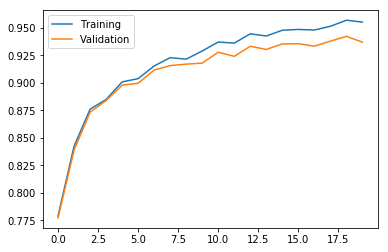

In [27]:
plt.plot([i for i in range(len(training_acc))], training_acc, label="Training")
plt.plot([i for i in range(len(training_acc))], validation_acc, label="Validation")
plt.legend()
plt.show()

In [28]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('../models'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models\lenet
Test Accuracy = 0.940
